# Problem Statement


Big industry players that provide cloud computing services such as Amazon and Google have been releasing Machine Learning as a service(MLaaS) lately and the department is interested in looking whether it is worth expanding their investment in such services provided. Currently, the company is the midst in expanding their infrastructure and department is interested in looking whether it is worth to include such services to reduce workload.


With a provided sample data, they would like the following outcome to further expedite their decision:


1.    Supervised classification model and compare the outcome together with a codeless AI platform 
2.   Explore other related services provided and if it it's worth the investment as whole

# Import Libraries & Data

In [ ]:
import pandas as pd
import numpy as np
import requests 
import datetime
import time
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_gbq

sns.set_theme()

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #mount google drive to google collab

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/accident-data.csv' #url to csv file

In [ ]:
df = pd.read_csv(url)

In [ ]:
df.shape

(91199, 27)

Have total of 91k and 27 rows in this data set

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   accident_index                           91199 non-null  object 
 1   accident_year                            91199 non-null  int64  
 2   accident_reference                       91199 non-null  object 
 3   longitude                                91185 non-null  float64
 4   latitude                                 91185 non-null  float64
 5   accident_severity                        91199 non-null  int64  
 6   number_of_vehicles                       91199 non-null  int64  
 7   number_of_casualties                     91199 non-null  int64  
 8   date                                     91199 non-null  object 
 9   day_of_week                              91199 non-null  int64  
 10  time                                     91199

Most of the columns are already in integer format except for time and date.\
To convert to datetime, extract month, weekofyear and year for further analysis\
Missing potential useful information such as seasonal and quarter related to date to know the trend for a particular time.\
Longitude and latitude are also in different columns. To put them together as a coordinate column

**Change datetime and time to datetime format and extract relevant information**

In [ ]:
df['time']= pd.to_datetime(df['time']) #convert time to date time and get the hour
df['hour']  = df['time'].dt.hour

In [ ]:
df['time'] = df['time'].dt.time

In [ ]:
df['date'] = pd.to_datetime(df['date']) #convert date to datetime
df['month'] = df['date'].dt.month #get month from date
df['doy'] = df['date'].dt.dayofyear #get dateof year 

In [ ]:
df['date'] =df['date'].dt.date

In [ ]:
df['day_of_week'] = df['day_of_week'].map({1:0,2:1,3:2,4:3,5:4,6:5,7:6}) #mapping it correct

In [ ]:
df['day_of_week'].unique()

array([2, 1, 3, 4, 5, 6, 0])

In [ ]:
df['day_of_week'].unique()

array([2, 1, 3, 4, 5, 6, 0])

**Determine season based on dateofyear**

In [ ]:
spring = range(80,172)
summer= range(172,264)
fall = range(264, 355)
season =[]

# "day of year" ranges for the northern hemisphere
for i in df['doy']:
    if i in spring:
        season.append('spring')
    elif i in summer:
        season.append('summer')
    elif i in fall:
        season.append('fall')
    else:
        season.append('winter')

In [ ]:
season_np = pd.Series(season)  
df['season'] = season_np #add season as a column in dataframe

In [ ]:
df.season.unique()

array(['spring', 'winter', 'summer', 'fall'], dtype=object)

In [ ]:
#drop doy
df.drop('doy', axis=1,inplace= True)

In [ ]:
df.iloc[65042]

accident_index                             2020432316294
accident_year                                       2020
accident_reference                             432316294
longitude                                      -0.801898
latitude                                         52.0381
accident_severity                                      3
number_of_vehicles                                     2
number_of_casualties                                   1
date                                          2020-06-10
day_of_week                                            2
time                                            15:30:00
first_road_class                                       6
first_road_number                                      0
road_type                                              6
speed_limit                                           20
junction_detail                                       -1
junction_control                                      -1
second_road_class              

**Concat longitude and latitude as coordinate**

In [ ]:
coords = []
for long, lat in zip(df.longitude, df.latitude):
    coords.append((long, lat))

In [ ]:
coords = pd.Series(coords)  
#df['coordinates'] = coords #add season as a column in dataframe

In [ ]:
df.head()

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,hour,month,season
0,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,2020-04-02,2,09:00:00,6,0,6,20,0,-1,6,0,9,9,1,9,9,0,0,1,9,4,spring
1,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,2020-04-27,1,13:55:00,3,3036,6,20,9,2,6,0,0,4,1,1,1,0,0,1,13,4,spring
2,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,2020-01-01,3,01:25:00,5,0,6,30,3,1,6,0,0,0,4,1,2,0,0,1,1,1,winter
3,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,2020-01-01,3,01:50:00,3,11,6,30,0,-1,6,0,0,4,4,1,1,0,0,1,1,1,winter
4,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,2020-01-01,3,02:25:00,3,40,6,30,3,4,5,0,0,0,4,1,1,0,0,1,2,1,winter


# Data Cleaning

## Check null values

In [ ]:
df.isnull().sum() #check null values

accident_index                              0
accident_year                               0
accident_reference                          0
longitude                                  14
latitude                                   14
accident_severity                           0
number_of_vehicles                          0
number_of_casualties                        0
date                                        0
day_of_week                                 0
time                                        0
first_road_class                            0
first_road_number                           0
road_type                                   0
speed_limit                                 0
junction_detail                             0
junction_control                            0
second_road_class                           0
second_road_number                          0
pedestrian_crossing_human_control           0
pedestrian_crossing_physical_facilities     0
light_conditions                  

Total of 14 longitudes and latitudes data and missing.\
However, based on the data lookup, those missing datas are indicated as -1.\
Due to the scope of the project , we are not going to impute the long_lat as it wont be use for the model later on but for further analysis thus to let it be.

In [ ]:
df.replace(-1,np.nan, regex=True,inplace=True) #replace -1 to NaN

In [ ]:
df.isnull().sum().sort_values(ascending=False) #check null values

junction_control                           38298
road_surface_conditions                      316
special_conditions_at_site                   218
carriageway_hazards                          208
pedestrian_crossing_human_control            143
pedestrian_crossing_physical_facilities      135
latitude                                      14
longitude                                     14
speed_limit                                   12
second_road_number                             7
junction_detail                                2
light_conditions                               1
weather_conditions                             1
day_of_week                                    0
accident_reference                             0
accident_year                                  0
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
date                                           0
season              

There are numerous null data found after translating -1 to NaN.\
To further drill down with histogram diagram below

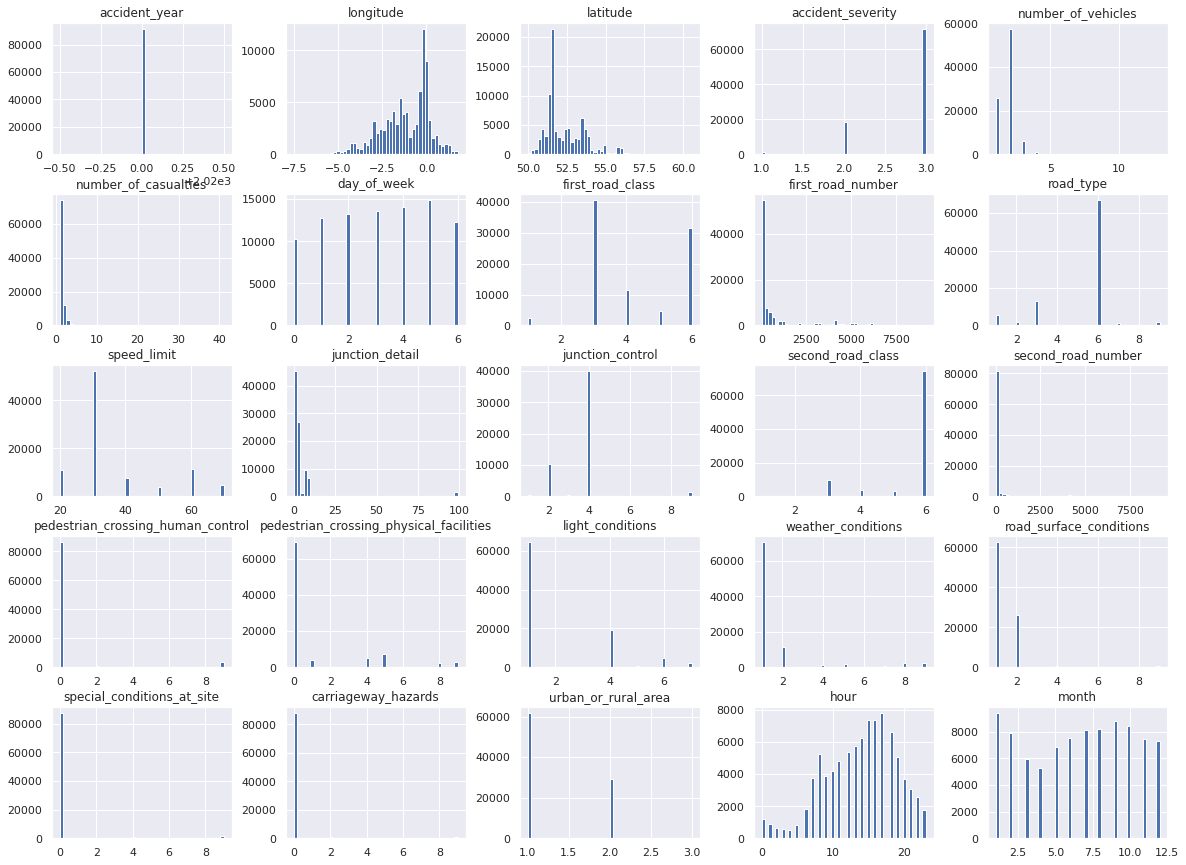

In [ ]:
df.hist(bins = 50, figsize = (20,15));

**Findings:**
- road_surface_conditions, special_conditions_at_site,carriageway_hazards columns majority of the data are in 0 variable which means "None" from the data lookup. This does not help the model nor is it useful for data visualization thus this columns will be drop
- second_road_class column data mostly belong to unclassified. As having 'unclassified' data does not help with the model, to drop the columns as well.
- junction_control have more than 5% null values thus to be dropped.

In [ ]:
df.drop(columns=['junction_control','road_surface_conditions', 'special_conditions_at_site',
                 'carriageway_hazards','second_road_class'],inplace=True,axis=1) 
#dropping the columns identified above,including index and reference as it wont be useful to the model

In [ ]:
df[['pedestrian_crossing_human_control','pedestrian_crossing_physical_facilities','second_road_number']].describe()

,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,second_road_number
count,91056.000000,91064.000000,91192.000000
mean,0.355100,1.188549,220.248969
std,1.698602,2.446288,913.725844
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,9.000000,9.000000,9174.000000


For this three columns also have most of their data from min to 75% at values of 0, this will also be dropped 

In [ ]:
df.drop(columns=['pedestrian_crossing_human_control','pedestrian_crossing_physical_facilities','second_road_number'],
        inplace=True,axis=1) #drop the columns stated above

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accident_index        91199 non-null  object 
 1   accident_year         91199 non-null  int64  
 2   accident_reference    91199 non-null  object 
 3   longitude             91185 non-null  float64
 4   latitude              91185 non-null  float64
 5   accident_severity     91199 non-null  int64  
 6   number_of_vehicles    91199 non-null  int64  
 7   number_of_casualties  91199 non-null  int64  
 8   date                  91199 non-null  object 
 9   day_of_week           91199 non-null  int64  
 10  time                  91199 non-null  object 
 11  first_road_class      91199 non-null  int64  
 12  first_road_number     91199 non-null  int64  
 13  road_type             91199 non-null  int64  
 14  speed_limit           91187 non-null  float64
 15  junction_detail    

## Impute features

**Impute junction_detail**

In [ ]:
df['junction_detail'].describe()

count    91197.000000
mean         3.934987
std         12.612895
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max         99.000000
Name: junction_detail, dtype: float64

In [ ]:
df[df['junction_detail'].isnull()]

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season
65042,2020432316294,2020,432316294,-0.801898,52.038080,3,2,1,2020-06-10,2,15:30:00,6,0,6,20.0,NaN,1.0,1.0,1,15,6,spring
80880,2020522003678,2020,522003678,-2.355525,51.389105,3,2,1,2020-11-08,2,08:25:00,6,0,6,30.0,NaN,1.0,1.0,1,8,11,fall


In [ ]:
df.iloc[65042,15] = 2

In [ ]:
df.iloc[80880,15] = 2

In [ ]:
df['junction_detail'].isnull().sum()

0

**Impute speed limit**

In [ ]:
df['speed_limit'].describe()

count    91187.000000
mean        36.275017
std         13.890367
min         20.000000
25%         30.000000
50%         30.000000
75%         40.000000
max         70.000000
Name: speed_limit, dtype: float64

In [ ]:
#check the rows where speed limit is null
speed_limit_null = df.loc[df['speed_limit'].isnull()]
speed_limit_null 


,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season
1993,2020010234355,2020,10234355,0.136269,51.532537,3,1,1,2020-03-02,1,21:20:00,6,0,3,NaN,2.0,4.0,1.0,1,21,3,winter
5381,2020010244932,2020,10244932,-0.171085,51.503893,3,1,1,2020-11-04,6,16:00:00,6,0,6,NaN,0.0,1.0,1.0,1,16,11,fall
16520,2020010275266,2020,010275266,0.145312,51.530753,2,1,1,2020-10-22,4,17:40:00,6,0,3,NaN,0.0,4.0,2.0,1,17,10,fall
18039,2020010279612,2020,010279612,0.013394,51.407327,3,1,1,2020-11-15,0,14:44:00,6,0,9,NaN,8.0,1.0,2.0,1,14,11,fall
18264,2020010280179,2020,010280179,-0.148194,51.358229,3,1,1,2020-11-19,4,12:21:00,6,0,9,NaN,99.0,1.0,9.0,1,12,11,fall
18487,2020010280770,2020,010280770,-0.018879,51.555683,3,2,1,2020-11-23,1,09:20:00,6,0,9,NaN,1.0,1.0,7.0,1,9,11,fall
20496,2020010286380,2020,010286380,-0.274291,51.499495,2,1,1,2020-12-21,1,20:50:00,6,0,2,NaN,6.0,7.0,1.0,1,20,12,winter
31115,2020101009449,2020,101009449,-1.455831,55.023670,2,1,1,2020-12-21,1,17:15:00,6,0,6,NaN,0.0,4.0,2.0,1,17,12,winter
47041,2020231004014,2020,231004014,-1.542189,52.471470,3,1,1,2020-11-30,1,07:45:00,6,0,2,NaN,0.0,1.0,1.0,2,7,11,fall
53894,2020350934310,2020,350934310,0.137331,52.194846,3,1,1,2020-02-26,3,09:30:00,6,0,6,NaN,0.0,1.0,1.0,1,9,2,winter


Observations: 
- Time range, month, season and road type varies
- 10/12 of this null values belongs occurs in the urban area
- Most of the accidents are in severity of 2 and 3 with only 1 casualties

In [ ]:
df.loc[df['urban_or_rural_area'] == 1]['speed_limit'].describe() #speed limit of urban

count    61727.000000
mean        29.835728
std          7.217370
min         20.000000
25%         30.000000
50%         30.000000
75%         30.000000
max         70.000000
Name: speed_limit, dtype: float64

For urban area, most of the speed at q1-q3 is at 30 km/h perhaps due to traffic light and dense area. 

In [ ]:
df.loc[df['urban_or_rural_area'] == 2]['speed_limit'].describe() #speed limit of rural

count    29446.000000
mean        49.768729
std         14.804465
min         20.000000
25%         30.000000
50%         60.000000
75%         60.000000
max         70.000000
Name: speed_limit, dtype: float64

The descriptive statistics seems to differ when location is in rural. Median seems to be at 60% as compared to urban. Perhaps due to highway and less traffic light, people seems to drive at higher speeds

In [ ]:
#check the rows where speed limit is null
speed_limit_null.loc[speed_limit_null['urban_or_rural_area'] == 1] ['speed_limit']


1993    NaN
5381    NaN
16520   NaN
18039   NaN
18264   NaN
18487   NaN
20496   NaN
31115   NaN
53894   NaN
68361   NaN
Name: speed_limit, dtype: float64

In [ ]:
speed_limit_null.loc[speed_limit_null['urban_or_rural_area'] == 2] ['speed_limit']

47041   NaN
55920   NaN
Name: speed_limit, dtype: float64

**impute urban or rural area ==1 to 30km/h in speed limit column**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accident_index        91199 non-null  object 
 1   accident_year         91199 non-null  int64  
 2   accident_reference    91199 non-null  object 
 3   longitude             91185 non-null  float64
 4   latitude              91185 non-null  float64
 5   accident_severity     91199 non-null  int64  
 6   number_of_vehicles    91199 non-null  int64  
 7   number_of_casualties  91199 non-null  int64  
 8   date                  91199 non-null  object 
 9   day_of_week           91199 non-null  int64  
 10  time                  91199 non-null  object 
 11  first_road_class      91199 non-null  int64  
 12  first_road_number     91199 non-null  int64  
 13  road_type             91199 non-null  int64  
 14  speed_limit           91187 non-null  float64
 15  junction_detail    

In [ ]:
urban_speed = df[(df['urban_or_rural_area'] == 1) & (df.speed_limit.isnull() )].index
urban_speed 

Int64Index([1993, 5381, 16520, 18039, 18264, 18487, 20496, 31115, 53894,
            68361],
           dtype='int64')

In [ ]:
for i in urban_speed :
  df.iloc[i,14]= 30

In [ ]:
urban_speed

Int64Index([1993, 5381, 16520, 18039, 18264, 18487, 20496, 31115, 53894,
            68361],
           dtype='int64')

**impute urban or rural area ==2 to 60km/h in speed limit column**

In [ ]:
df[(df['urban_or_rural_area'] == 2) & (df.speed_limit.isnull() )]

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season
47041,2020231004014,2020,231004014,-1.542189,52.471470,3,1,1,2020-11-30,1,07:45:00,6,0,2,NaN,0.0,1.0,1.0,2,7,11,fall
55920,2020360993413,2020,360993413,0.236208,52.508668,3,1,1,2020-09-14,1,15:55:00,6,0,6,NaN,0.0,1.0,1.0,2,15,9,summer


In [ ]:
df.iloc[47041,14] = 60

In [ ]:
df.iloc[55920,14] = 60

In [ ]:
df.isnull().sum()

accident_index           0
accident_year            0
accident_reference       0
longitude               14
latitude                14
accident_severity        0
number_of_vehicles       0
number_of_casualties     0
date                     0
day_of_week              0
time                     0
first_road_class         0
first_road_number        0
road_type                0
speed_limit              0
junction_detail          0
light_conditions         1
weather_conditions       1
urban_or_rural_area      0
hour                     0
month                    0
season                   0
dtype: int64

**Impute light conditions**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accident_index        91199 non-null  object 
 1   accident_year         91199 non-null  int64  
 2   accident_reference    91199 non-null  object 
 3   longitude             91185 non-null  float64
 4   latitude              91185 non-null  float64
 5   accident_severity     91199 non-null  int64  
 6   number_of_vehicles    91199 non-null  int64  
 7   number_of_casualties  91199 non-null  int64  
 8   date                  91199 non-null  object 
 9   day_of_week           91199 non-null  int64  
 10  time                  91199 non-null  object 
 11  first_road_class      91199 non-null  int64  
 12  first_road_number     91199 non-null  int64  
 13  road_type             91199 non-null  int64  
 14  speed_limit           91199 non-null  float64
 15  junction_detail    

In [ ]:
df.loc[df['light_conditions'].isnull()]

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season
79777,2020520002488,2020,520002488,-2.809007,51.288686,1,1,1,2020-06-24,3,01:15:00,3,371,6,60.0,0.0,NaN,NaN,2,1,6,summer


The date for this missing row is 24 06 2020. Will use this date and hour to get the light conditions

In [ ]:
x = datetime.datetime(2020, 6, 24)

x = x.date()

x #make the date to datetime format

datetime.date(2020, 6, 24)

In [ ]:
df.loc[(df['date'] == x)&  (df['hour'] == 1)] #get rows where date == the missing row and hour is 1 

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season
14509,2020010269806,2020,10269806,-0.198054,51.554400,2,2,1,2020-06-24,3,01:26:00,6,0,9,30.0,99.0,4.0,1.0,1,1,6,summer
22664,2020040960386,2020,040960386,-3.044452,53.815102,3,1,1,2020-06-24,3,01:00:00,4,5263,6,30.0,6.0,4.0,1.0,1,1,6,summer
60763,2020420959369,2020,420959369,0.412262,51.693004,3,2,1,2020-06-24,3,01:05:00,6,0,6,30.0,3.0,6.0,1.0,2,1,6,summer
79777,2020520002488,2020,520002488,-2.809007,51.288686,1,1,1,2020-06-24,3,01:15:00,3,371,6,60.0,0.0,NaN,NaN,2,1,6,summer


As row 22664 long_lat is closer to the missing row, will use the information from that row to impute the light conditions and weather condition

In [ ]:
df.iloc[79777,16] = 4 #impute light condition

In [ ]:
df.iloc[79777,17] = 1 #imput weather

In [ ]:
df.loc[df['light_conditions'].isnull()]

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season


Check once again on null values and duplicated values

In [ ]:
df.isnull().sum().sort_values(ascending=False) #check null values

longitude               14
latitude                14
season                   0
month                    0
accident_year            0
accident_reference       0
accident_severity        0
number_of_vehicles       0
number_of_casualties     0
date                     0
day_of_week              0
time                     0
first_road_class         0
first_road_number        0
road_type                0
speed_limit              0
junction_detail          0
light_conditions         0
weather_conditions       0
urban_or_rural_area      0
hour                     0
accident_index           0
dtype: int64

In [ ]:
df.duplicated().sum()

0

Two duplicates found. To drop them.

In [ ]:
df.drop_duplicates(inplace=False)

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season
0,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,2020-04-02,2,09:00:00,6,0,6,20.0,0.0,1.0,9.0,1,9,4,spring
1,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,2020-04-27,1,13:55:00,3,3036,6,20.0,9.0,1.0,1.0,1,13,4,spring
2,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,2020-01-01,3,01:25:00,5,0,6,30.0,3.0,4.0,1.0,1,1,1,winter
3,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,2020-01-01,3,01:50:00,3,11,6,30.0,0.0,4.0,1.0,1,1,1,winter
4,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,2020-01-01,3,02:25:00,3,40,6,30.0,3.0,4.0,1.0,1,2,1,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91194,2020991027064,2020,991027064,-2.926320,56.473539,2,2,1,2020-12-08,3,14:30:00,4,959,6,30.0,1.0,1.0,1.0,1,14,12,fall
91195,2020991029573,2020,991029573,-4.267565,55.802353,3,1,1,2020-11-13,5,15:05:00,6,0,9,30.0,3.0,1.0,1.0,1,15,11,fall
91196,2020991030297,2020,991030297,-2.271903,57.186317,2,2,1,2020-04-15,3,12:42:00,4,979,6,60.0,8.0,1.0,1.0,2,12,4,spring
91197,2020991030900,2020,991030900,-3.968753,55.950940,3,2,1,2020-12-15,2,14:00:00,6,0,6,30.0,3.0,1.0,1.0,1,14,12,fall


In [ ]:
df.head()

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season
0,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,2020-04-02,2,09:00:00,6,0,6,20.0,0.0,1.0,9.0,1,9,4,spring
1,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,2020-04-27,1,13:55:00,3,3036,6,20.0,9.0,1.0,1.0,1,13,4,spring
2,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,2020-01-01,3,01:25:00,5,0,6,30.0,3.0,4.0,1.0,1,1,1,winter
3,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,2020-01-01,3,01:50:00,3,11,6,30.0,0.0,4.0,1.0,1,1,1,winter
4,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,2020-01-01,3,02:25:00,3,40,6,30.0,3.0,4.0,1.0,1,2,1,winter


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accident_index        91199 non-null  object 
 1   accident_year         91199 non-null  int64  
 2   accident_reference    91199 non-null  object 
 3   longitude             91185 non-null  float64
 4   latitude              91185 non-null  float64
 5   accident_severity     91199 non-null  int64  
 6   number_of_vehicles    91199 non-null  int64  
 7   number_of_casualties  91199 non-null  int64  
 8   date                  91199 non-null  object 
 9   day_of_week           91199 non-null  int64  
 10  time                  91199 non-null  object 
 11  first_road_class      91199 non-null  int64  
 12  first_road_number     91199 non-null  int64  
 13  road_type             91199 non-null  int64  
 14  speed_limit           91199 non-null  float64
 15  junction_detail    

# EDA

## Correlation of values

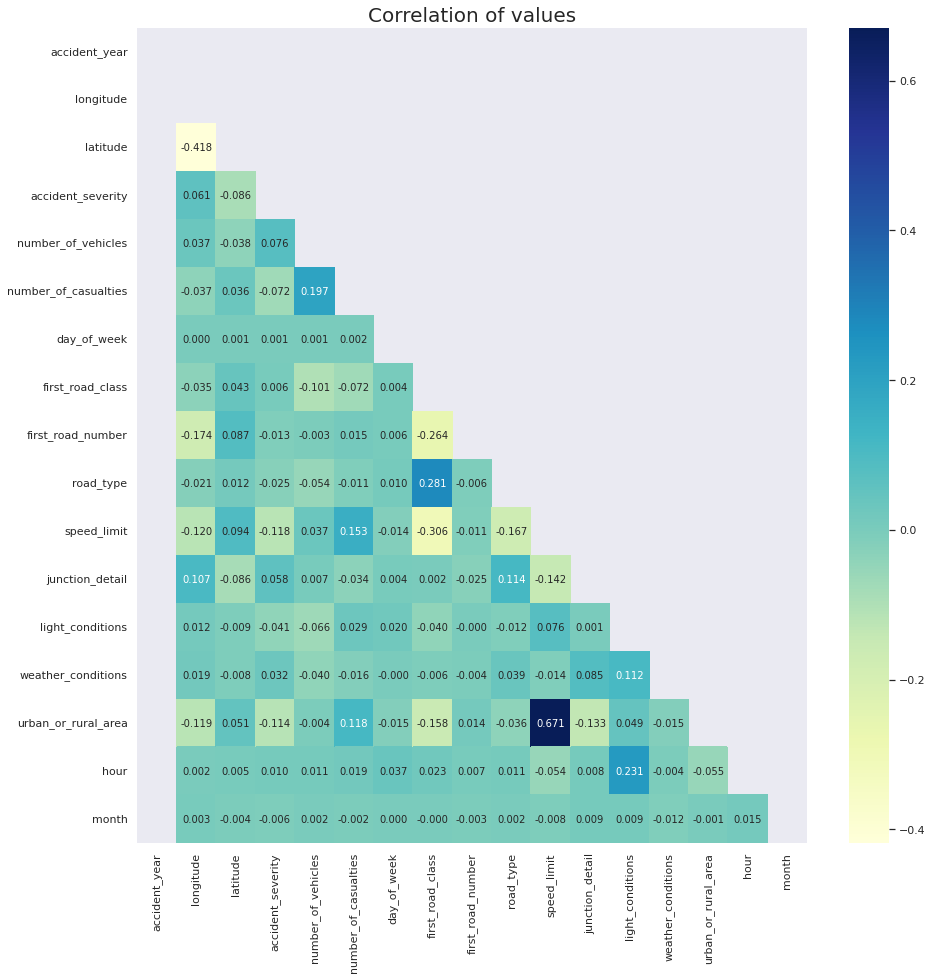

In [ ]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (15,15))
plt.title('Correlation of values',size=20)
sns.heatmap(data = df.corr(),mask=mask, annot=True, fmt='.3f',cmap = "YlGnBu")
plt.show()

This diagram shows that there are not much correlation especially to the target variavble, accident_severity. The only strongly corrrelated are urban_or_rural_area are and speed_limit. This shows that that perhaps when vehicles are at rural area, accidents involve tend to be at a higher speed limit since there are no traffic lights and speed limit also tends to be higher

## Acccident Severity

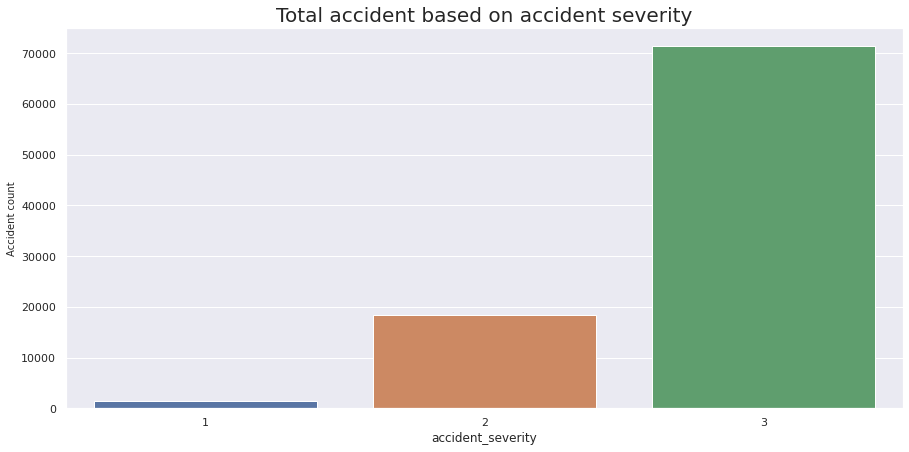

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df.accident_severity,data=df)
plt.title('Total accident based on accident severity' , fontsize= 20)
plt.ylabel('Accident count' , fontsize = 10);

This shows that there is a imbalance dataset for this target variable with least common 1(slight) with only roughly at 1k data and most common 3(slight) at 70k.

## Urban or rural area

In [ ]:
df[df['urban_or_rural_area'] == 3]

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season
25520,2020052002442,2020,052002442,NaN,NaN,2,2,1,2020-11-26,4,16:00:00,3,5038,3,40.0,6.0,1.0,1.0,3,16,11,fall
29452,2020070769852,2020,070769852,NaN,NaN,3,2,1,2020-12-19,6,11:10:00,3,5268,6,40.0,3.0,1.0,1.0,3,11,12,fall
32689,2020122001194,2020,122001194,NaN,NaN,3,2,2,2020-09-30,3,18:10:00,6,0,9,60.0,3.0,1.0,2.0,3,18,9,fall
33578,2020137330369,2020,137330369,NaN,NaN,3,2,1,2020-03-03,2,09:16:00,1,62,3,50.0,1.0,1.0,1.0,3,9,3,winter
81252,2020522005114,2020,522005114,NaN,NaN,3,3,2,2020-05-29,5,19:00:00,3,370,1,40.0,1.0,7.0,1.0,3,19,5,spring
86437,2020622001016,2020,622001016,NaN,NaN,3,2,1,2020-11-13,5,20:16:00,6,0,6,20.0,9.0,4.0,1.0,3,20,11,fall
86642,202063A017520,2020,63A017520,NaN,NaN,3,2,1,2020-02-26,3,08:15:00,4,4298,6,50.0,0.0,1.0,9.0,3,8,2,winter
86651,202063A018920,2020,63A018920,NaN,NaN,3,2,1,2020-02-27,4,05:55:00,4,4303,6,30.0,3.0,1.0,9.0,3,5,2,winter
86668,202063A025020,2020,63A025020,NaN,NaN,3,2,1,2020-12-02,3,08:15:00,4,4306,6,30.0,0.0,1.0,2.0,3,8,12,fall
86705,202063A035620,2020,63A035620,NaN,NaN,3,1,1,2020-10-06,3,18:35:00,6,0,6,60.0,0.0,1.0,1.0,3,18,10,fall


Those urban or rural areas that are not allocated also have their longitude and latitude missing. However, we will ignore them as it's less than 1% of data.

In [ ]:
df.groupby(['urban_or_rural_area']).size()

urban_or_rural_area
1    61737
2    29448
3       14
dtype: int64

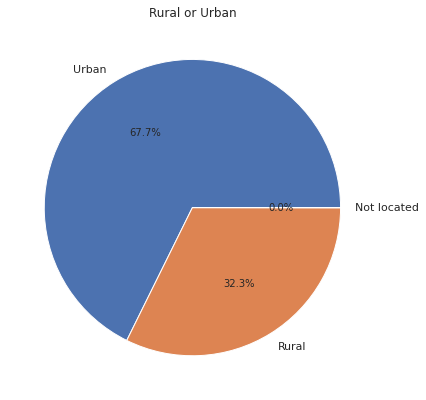

In [ ]:
labels = ['Urban', 'Rural', 'Not located']
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(df.groupby(['urban_or_rural_area']).size(), labels=labels, autopct='%.1f%%')
ax.set_title('Rural or Urban')
plt.tight_layout()

In [ ]:
df.groupby(['urban_or_rural_area', 'accident_severity']).size().unstack()

accident_severity,1,2,3
urban_or_rural_area,,,
1,534.0,11015.0,50188.0
2,857.0,7338.0,21253.0
3,NaN,2.0,12.0


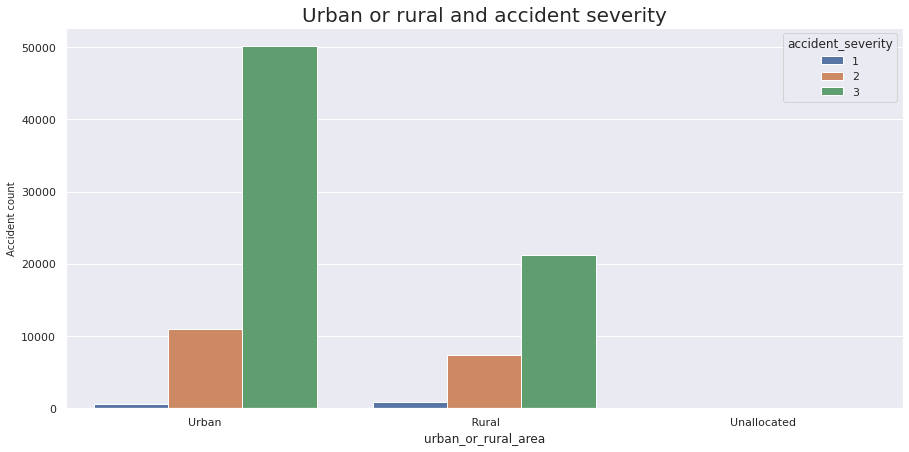

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x=df.urban_or_rural_area,data=df, hue = 'accident_severity')
plt.title('Urban or rural and accident severity' , fontsize= 20)
plt.ylabel('Accident count' , fontsize = 10)
ax.set_xticklabels(['Urban' , ' Rural' , 'Unallocated']);

This shows that more accidents are found in urban area in general but however, there is more records with accident severity 1 in rural area. This is perhaps due to higher speed limit comparing to urban areas.

## Number of casualties

In [ ]:
df['number_of_casualties'].describe()

count    91199.000000
mean         1.267382
std          0.681473
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
Name: number_of_casualties, dtype: float64

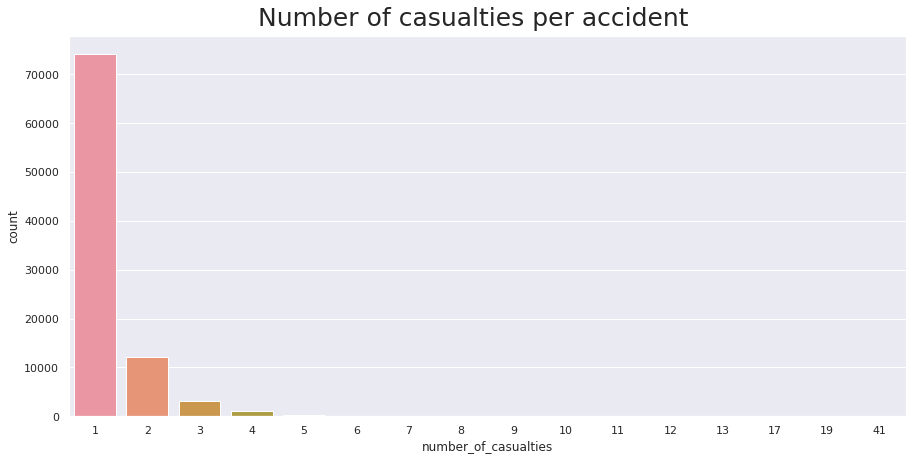

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['number_of_casualties'],data = df)
plt.figtext(.5,.9,'Number of casualties per accident', fontsize=25, ha='center');

This shows that most of the accident found only involve 1 casualty 

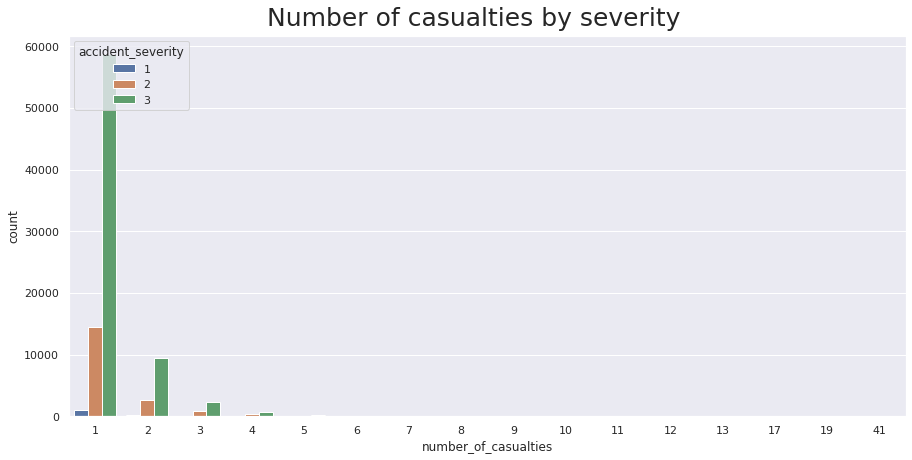

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['number_of_casualties'],data = df, hue='accident_severity')
plt.figtext(.5,.9,'Number of casualties by severity', fontsize=25, ha='center')
plt.yticks()
plt.xticks();

## Number of vehicles

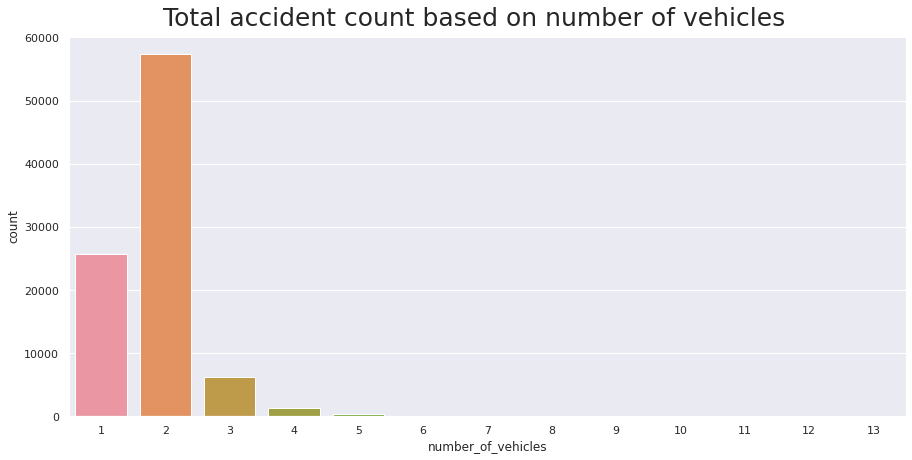

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['number_of_vehicles'],data = df)
plt.figtext(.5,.9,'Total accident count based on number of vehicles', fontsize=25, ha='center');

Most accidents involve are with 2 vehicles. This shows that perhaps more accidents involve with vehicle collision than vehicle-human collision

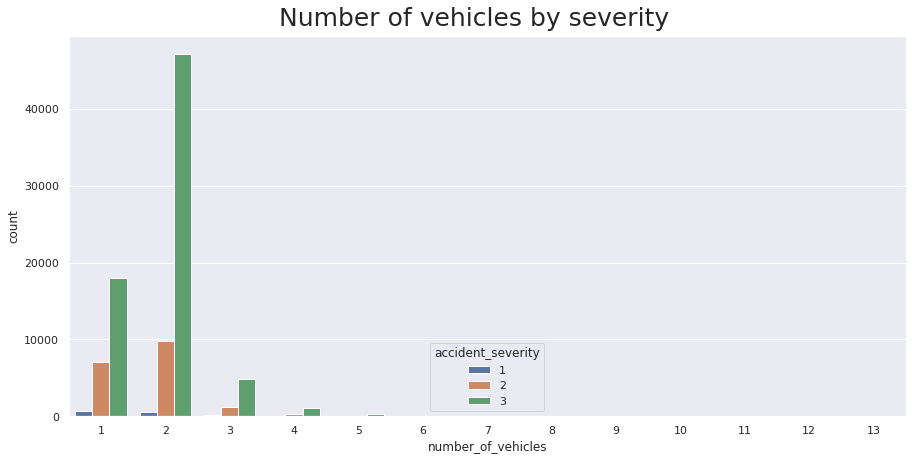

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['number_of_vehicles'],data = df, hue='accident_severity')
plt.figtext(.5,.9,'Number of vehicles by severity', fontsize=25, ha='center');

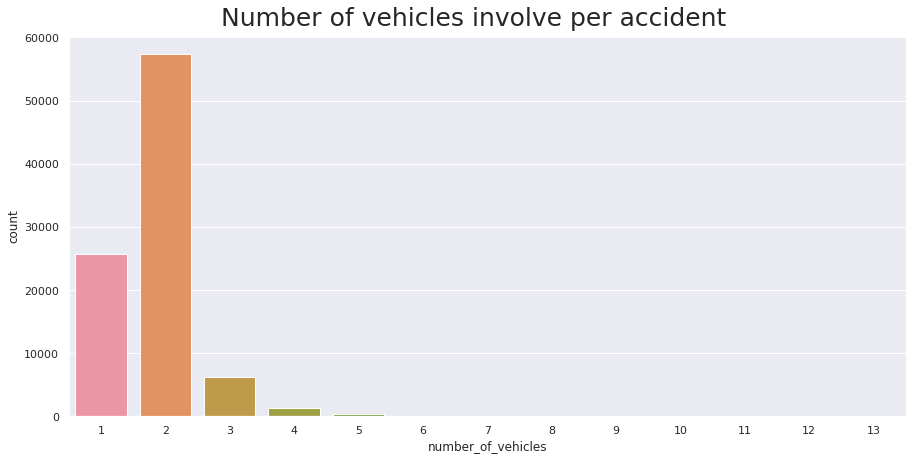

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['number_of_vehicles'],data = df)
plt.figtext(.5,.9,'Number of vehicles involve per accident', fontsize=25, ha='center');

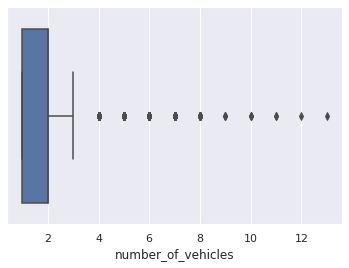

In [ ]:
sns.boxplot(data=df,x=df['number_of_vehicles']);

## Road type

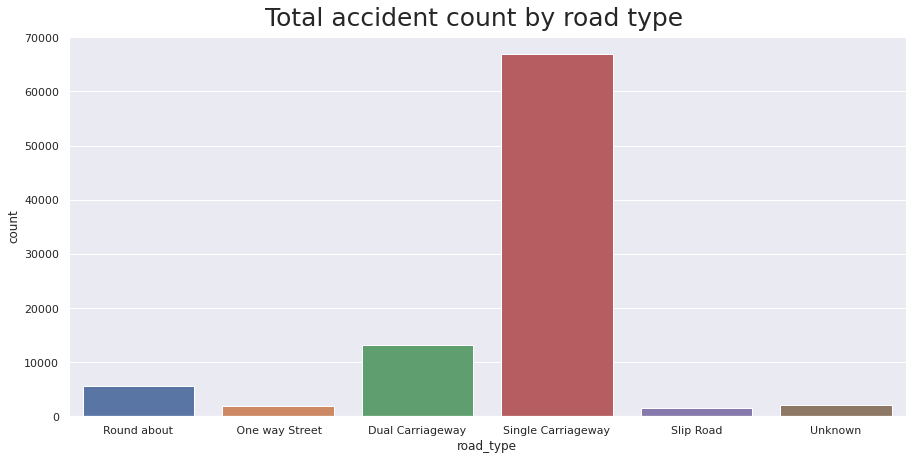

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x=df['road_type'],data = df)
plt.figtext(.5,.9,'Total accident count by road type', fontsize=25, ha='center')
ax.set_xticklabels(['Round about',' One way Street' , 'Dual Carriageway' ,  'Single Carriageway' , 'Slip Road' ,  'Unknown']);

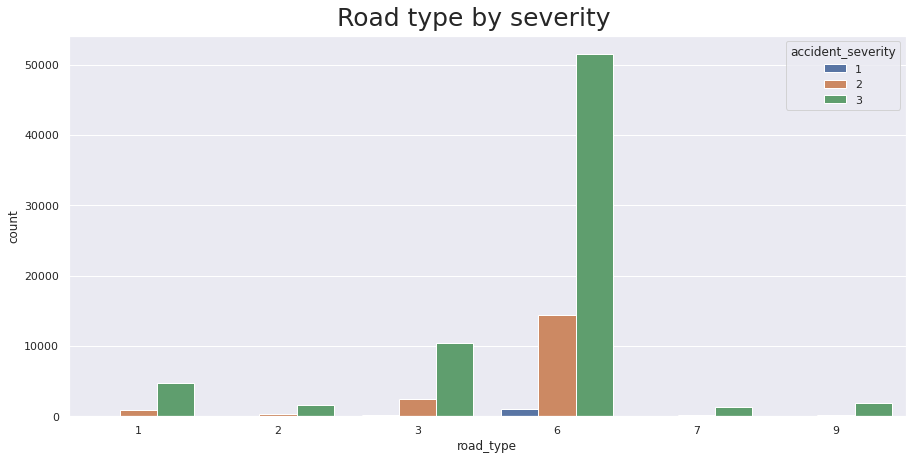

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['road_type'],data = df, hue='accident_severity')
plt.figtext(.5,.9,'Road type by severity', fontsize=25, ha='center')
plt.yticks()
plt.xticks();

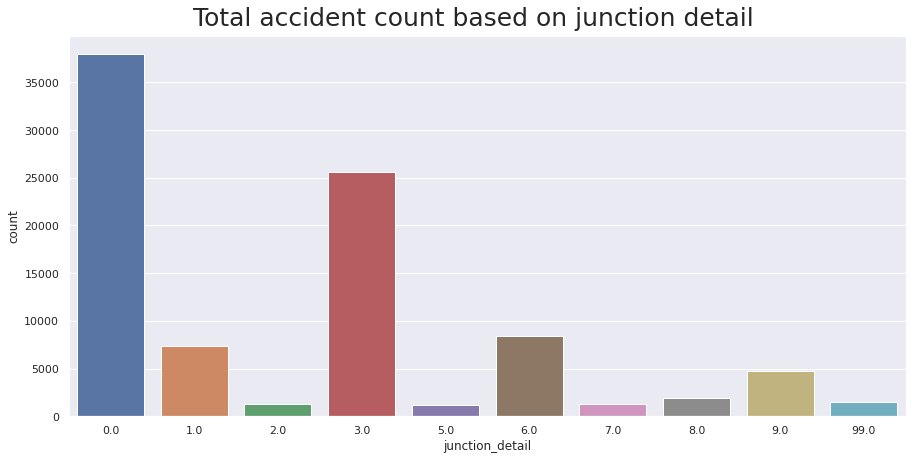

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['junction_detail'],data = df)
plt.figtext(.5,.9,'Total accident count based on junction detail', fontsize=25, ha='center');

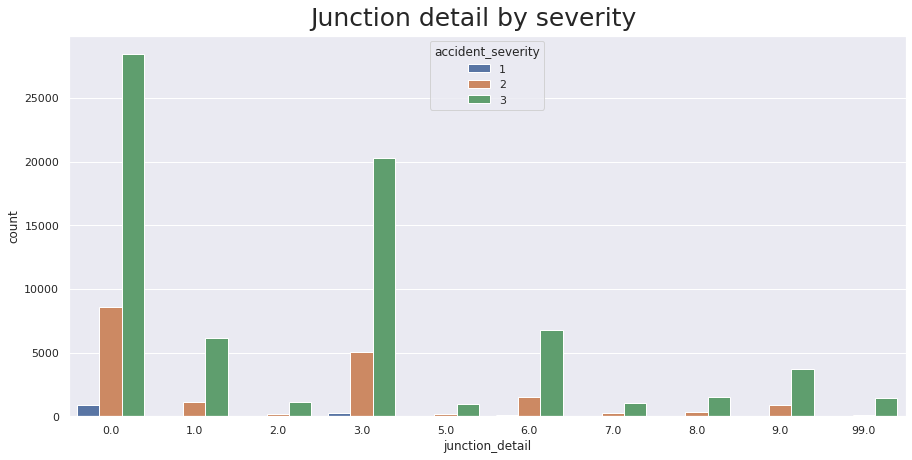

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['junction_detail'],data = df, hue='accident_severity')
plt.figtext(.5,.9,'Junction detail by severity', fontsize=25, ha='center')
plt.yticks()
plt.xticks();

In [ ]:
df['first_road_number'].describe()

count    91199.000000
mean       790.666071
std       1580.817743
min          0.000000
25%          0.000000
50%         34.000000
75%        538.000000
max       9174.000000
Name: first_road_number, dtype: float64

## Light Conditions

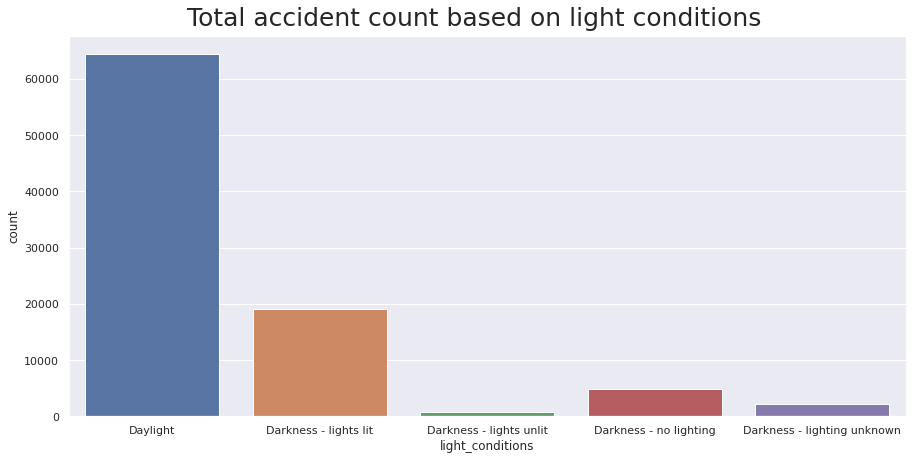

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x=df['light_conditions'],data = df)
plt.figtext(.5,.9,'Total accident count based on light conditions', fontsize=25, ha='center')
ax.set_xticklabels(['Daylight','Darkness - lights lit','Darkness - lights unlit','Darkness - no lighting','Darkness - lighting unknown']);

## Season

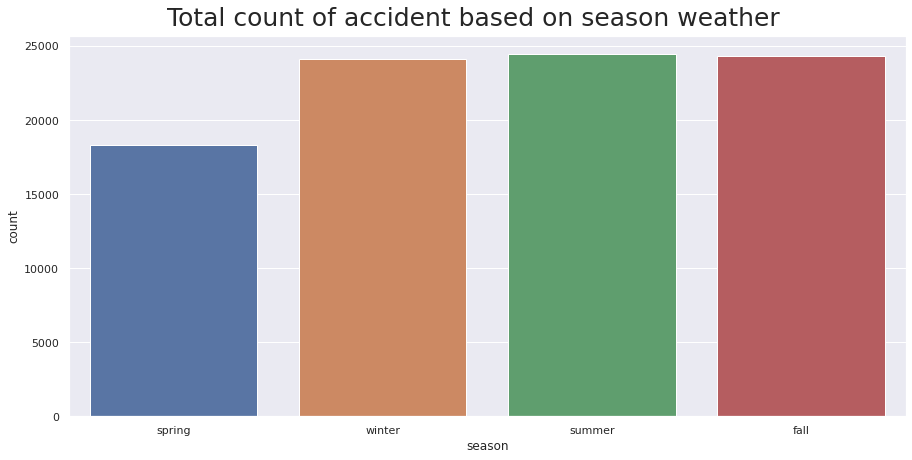

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['season'],data = df)  
plt.figtext(.5,.9,'Total count of accident based on season weather', fontsize=25, ha='center');

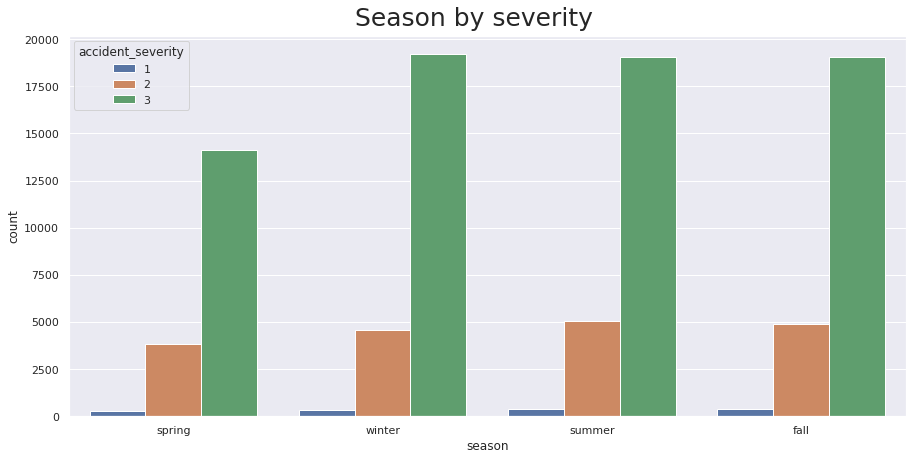

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['season'],data = df, hue='accident_severity')   
plt.figtext(.5,.9,'Season by severity', fontsize=25, ha='center')
plt.yticks()
plt.xticks();

# Location

In [ ]:
import plotly.express as px

In [ ]:
serious = df.loc[df['number_of_casualties'] >= 3]

# Create scatter plot
fig = px.scatter_mapbox(serious, lat = 'latitude', lon = 'longitude', color = 'number_of_vehicles',
                        size = 'number_of_casualties', color_continuous_scale = px.colors.sequential.Bluered,
                        size_max = 15, zoom = 5, height = 600)

fig.update_layout(mapbox_style = 'open-street-map')
fig.show()

In [ ]:
serious = df.loc[df['accident_severity'] ==1]

# Create scatter plot
fig = px.scatter_mapbox(serious, lat = 'latitude', lon = 'longitude', color = 'number_of_vehicles',
                        size = 'number_of_casualties', color_continuous_scale = px.colors.sequential.Bluered,
                        size_max = 15, zoom = 5, height = 600)

fig.update_layout(mapbox_style = 'open-street-map')
fig.show()

In [ ]:
serious = df.loc[(df['hour'] >=17) & (df['hour'] == 20)]

# Create scatter plot
fig = px.scatter_mapbox(serious, lat = 'latitude', lon = 'longitude', color = 'accident_severity',
                        size = 'number_of_casualties', color_continuous_scale = px.colors.sequential.Bluered,
                        size_max = 15, zoom = 5, height = 600)

fig.update_layout(mapbox_style = 'open-street-map')
fig.show()

## Time series 

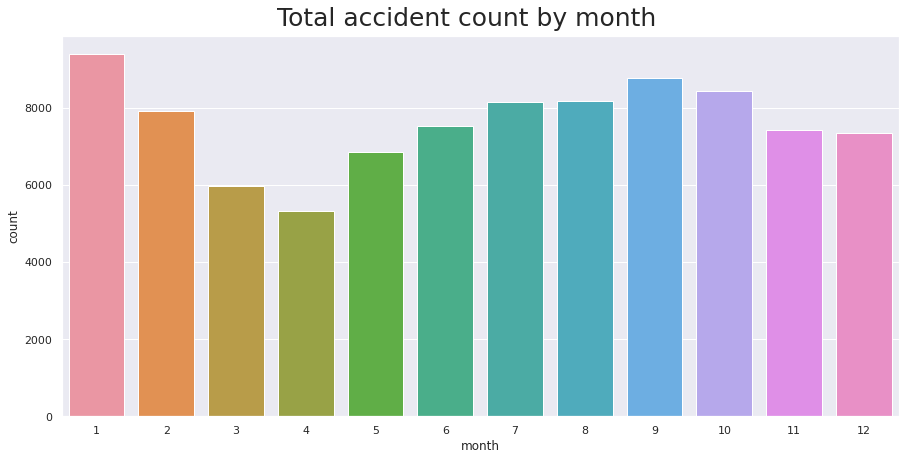

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['month'],data = df)   
plt.figtext(.5,.9,'Total accident count by month', fontsize=25, ha='center')
plt.yticks()
plt.xticks();

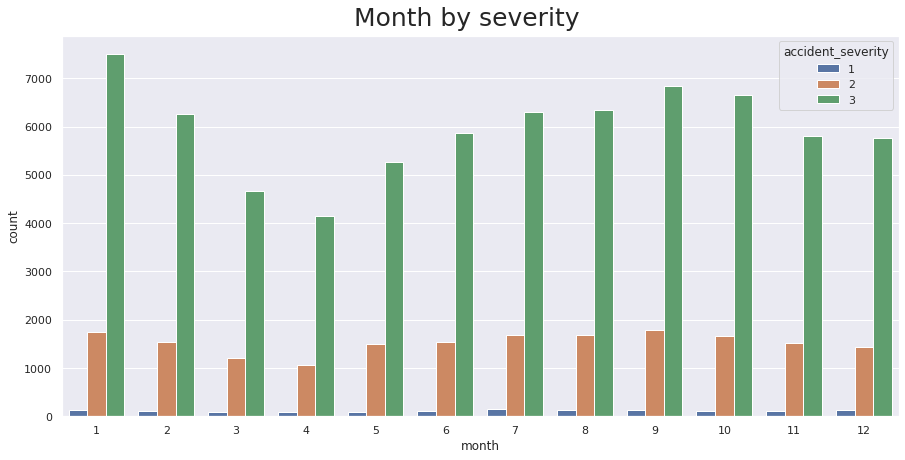

In [ ]:
plt.figure(figsize=[15,7])
sns.countplot(x=df['month'],data = df, hue='accident_severity')   
plt.figtext(.5,.9,'Month by severity', fontsize=25, ha='center')
plt.yticks()
plt.xticks();

This shows that january generally have higher accident but however, July have higher accident belonging that is fatal.

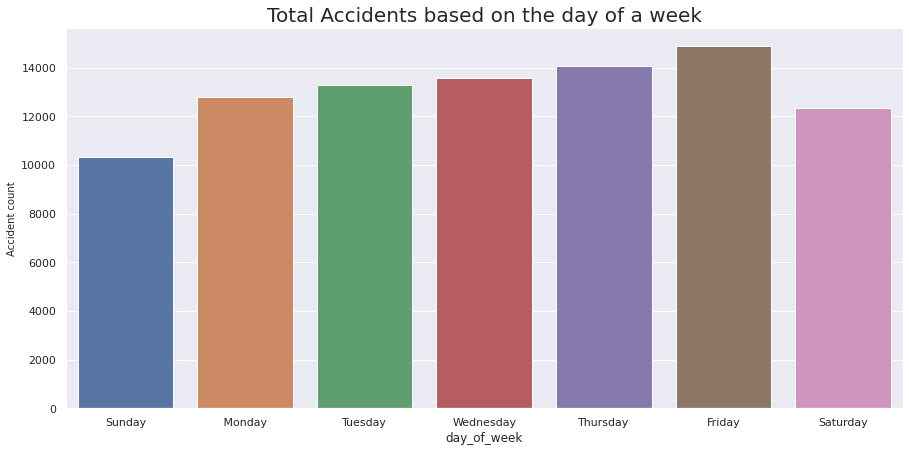

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x=df.day_of_week,data=df)
plt.title('Total Accidents based on the day of a week' , fontsize= 20)
plt.ylabel('Accident count' , fontsize = 10)
ax.set_xticklabels(['Sunday',' Monday ' , 'Tuesday' ,  'Wednesday' , 'Thursday' ,  'Friday' , 'Saturday']);

In [ ]:
a = df.groupby(['day_of_week']).size().transform('mean')

ValueError: ignored

In [ ]:
a

,day_of_week,0
0,0,10315
1,1,12772
2,2,13267
3,3,13564
4,4,14056
5,5,14889
6,6,12336


In [ ]:
a[0].mean()

13028.42857142857

''

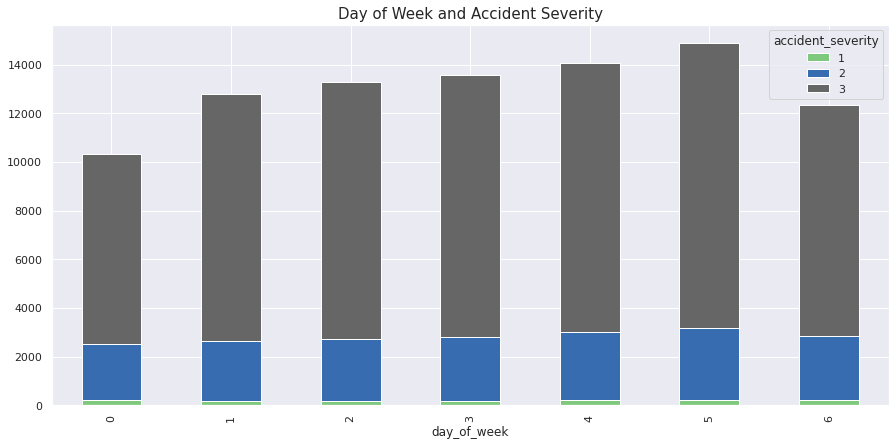

In [ ]:
df.groupby(['day_of_week','accident_severity']).size().unstack().plot(kind='bar',stacked=True,figsize=(15,7) ,cmap='Accent')

plt.title('Day of Week and Accident Severity',size = 15)
;

This diagram shows that Fridays have more accident counts in general and for all accident severity. This is perhaps due to the start of weekend and people rushing to go back home.

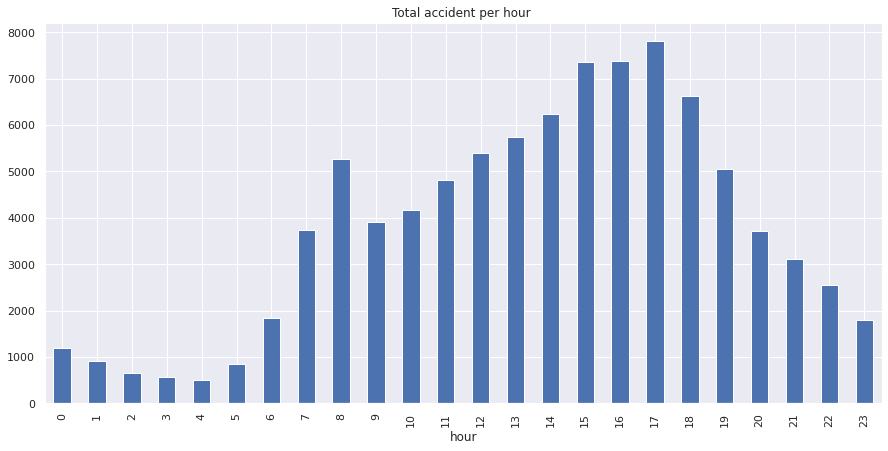

In [ ]:
#time series per hour 
df.groupby(['hour']).size().plot(figsize=(15,7), title='Total accident per hour ', kind='bar');

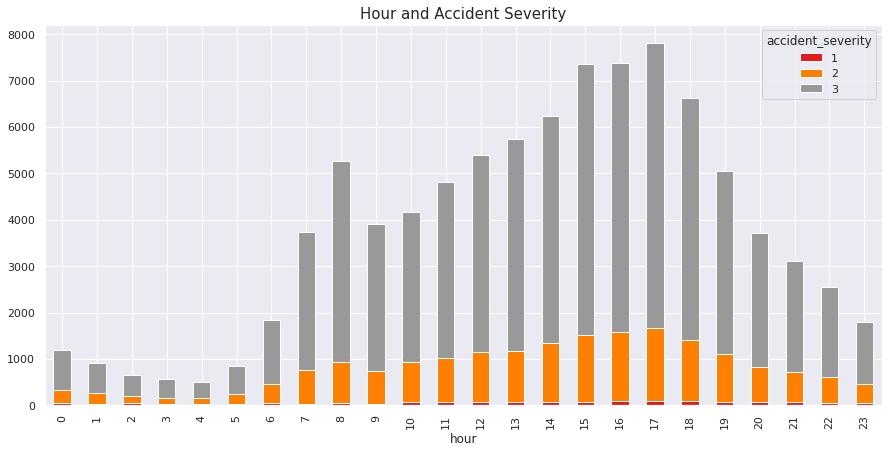

In [ ]:
 df.groupby(['hour','accident_severity']).size().unstack().plot(kind='bar',stacked=True,figsize=(15,7), cmap='Set1')
plt.title('Hour and Accident Severity',size = 15)
sns.color_palette("husl", 8);

Accident count tend to peak at peak hours. For morning peak hour, count tend to peak at 8AM  and for evening peak hour it peak at 5pm for all accident severity.

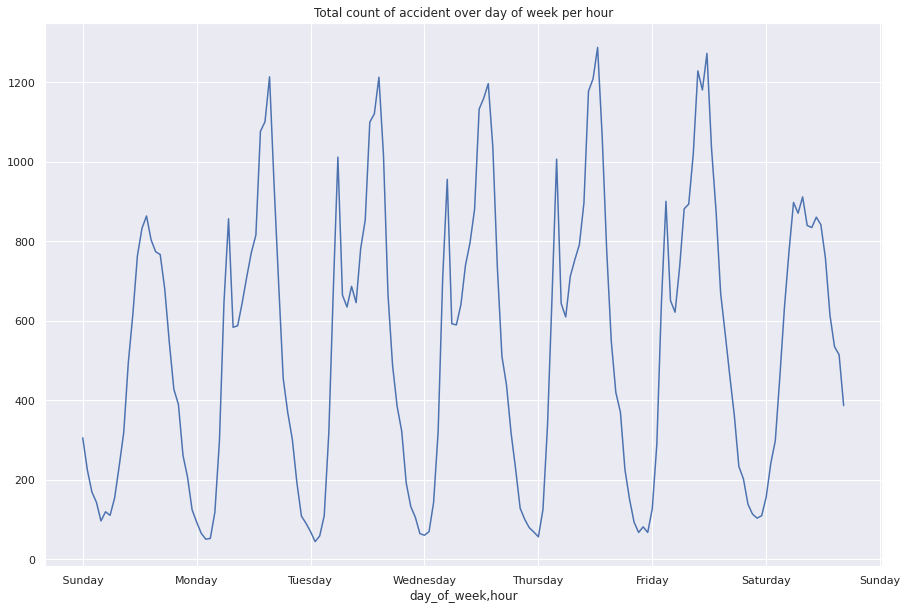

In [ ]:
ax = df.groupby(['day_of_week','hour']).size().plot(figsize=(15,10),title='Total count of accident over day of week per hour');
ax.set_xticklabels([' ',' Sunday ' , 'Monday', 'Tuesday' ,  'Wednesday' , 'Thursday' ,  'Friday' , 'Saturday', 'Sunday']);

In [ ]:
df.groupby(['hour','day_of_week']).size().sort_values(ascending=False).head(10)

hour  day_of_week
17    4              1288
      5              1273
15    5              1229
17    1              1214
      2              1213
16    4              1209
17    3              1197
16    5              1181
15    4              1178
16    3              1160
dtype: int64

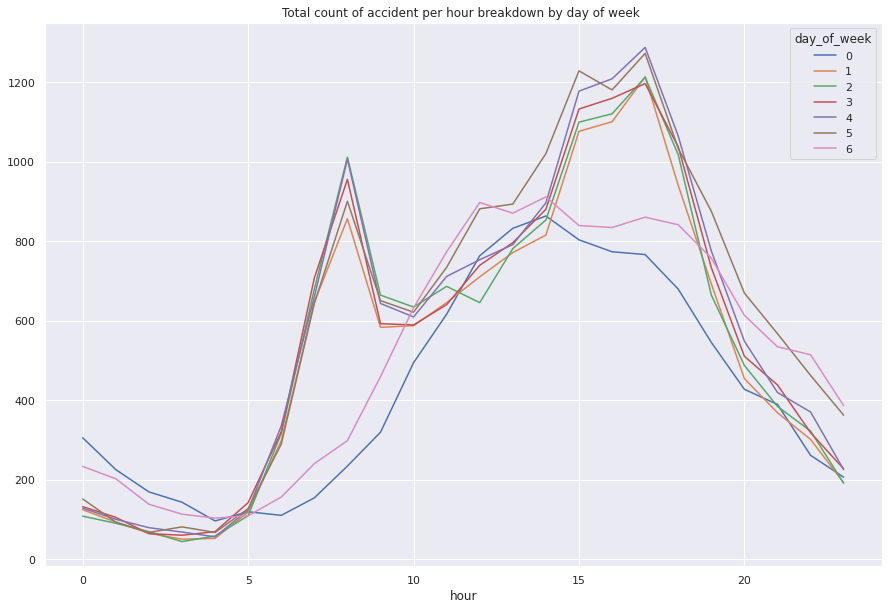

In [ ]:
df.groupby(['hour','day_of_week']).size().unstack().plot(figsize=(15,10),title='Total count of accident per hour breakdown by day of week ');

In [ ]:
df.groupby(['month','day_of_week']).size().sort_values(ascending=False).head(10)

month  day_of_week
10     5              1790
1      2              1777
7      5              1734
11     5              1584
9      3              1574
10     4              1550
9      1              1533
1      3              1496
8      6              1470
2      4              1466
dtype: int64

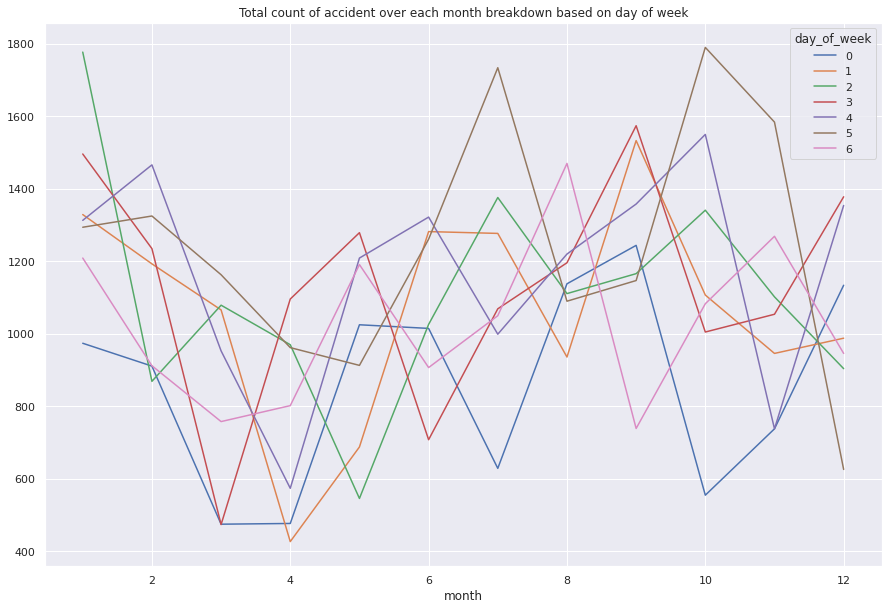

In [ ]:
df.groupby(['month','day_of_week']).size().unstack().plot(figsize=(15,10),title='Total count of accident over each month breakdown based on day of week');

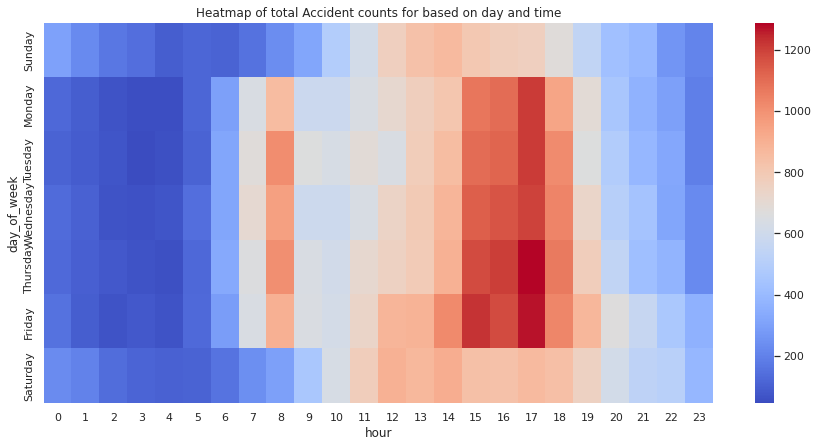

In [ ]:
#heatmap for hour and day of week 
plt.figure(figsize=(15,7))
plt.title('Heatmap of total Accident counts for based on day and time')
g = sns.heatmap(df.groupby(['day_of_week','hour']).size().unstack(), cmap='coolwarm')
g.set_yticklabels(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']);

This heatmap shows the peak hour based on accident hour

1.   Morning peak hour starts at 7AM till 9AM 
2.   Evening peak hour starts at 3AM till 6PM
3.   Lunch peak hour at 11AM till 2PM



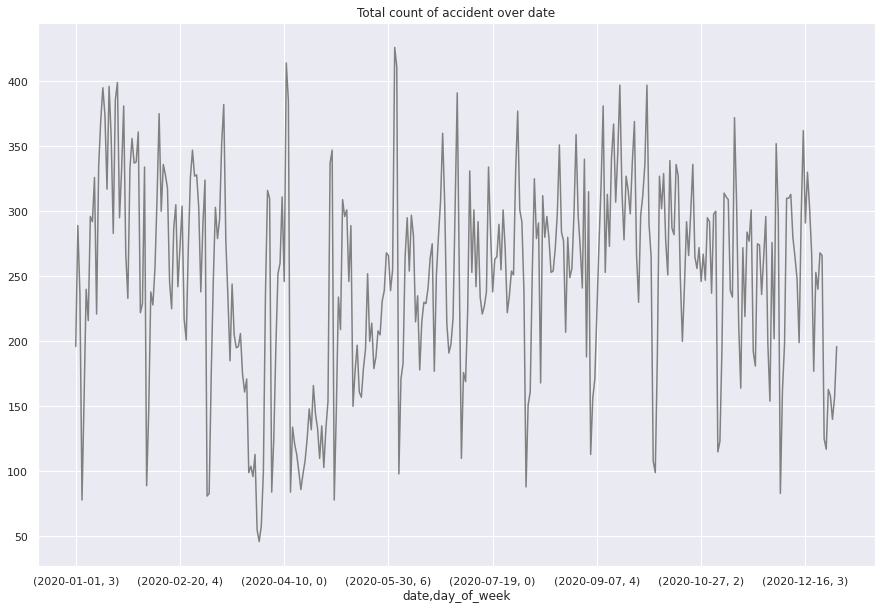

In [ ]:
df.groupby(['date','day_of_week']).size().plot(figsize=(15,10),title='Total count of accident over date', color='grey');

#Save clean data to bigquery and csv

In [ ]:
import warnings
warnings.simplefilter("always", category=PendingDeprecationWarning) 
warnings.simplefilter("always", category=DeprecationWarning) 

In [ ]:
df['accident_reference']= df['accident_reference'].astype(str) #convert this column to string to indicate that it is a string type in bigquery

In [ ]:
df['accident_index'] = df['accident_index'].astype(str) #convert this column to string to indicate that it is a string type in bigquery

In [ ]:
df['coords'] = df['latitude'].map(str)+ ','+ df['longitude'].map(str)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accident_index        91199 non-null  object 
 1   accident_year         91199 non-null  int64  
 2   accident_reference    91199 non-null  object 
 3   longitude             91185 non-null  float64
 4   latitude              91185 non-null  float64
 5   accident_severity     91199 non-null  int64  
 6   number_of_vehicles    91199 non-null  int64  
 7   number_of_casualties  91199 non-null  int64  
 8   date                  91199 non-null  object 
 9   day_of_week           91199 non-null  int64  
 10  time                  91199 non-null  object 
 11  first_road_class      91199 non-null  int64  
 12  first_road_number     91199 non-null  int64  
 13  road_type             91199 non-null  int64  
 14  speed_limit           91199 non-null  float64
 15  junction_detail    

In [ ]:
df.head()

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,first_road_class,first_road_number,road_type,speed_limit,junction_detail,light_conditions,weather_conditions,urban_or_rural_area,hour,month,season,coords
0,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,2020-04-02,2,09:00:00,6,0,6,20.0,0.0,1.0,9.0,1,9,4,spring,"51.462262,-0.25400100000000003"
1,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,2020-04-27,1,13:55:00,3,3036,6,20.0,9.0,1.0,1.0,1,13,4,spring,"51.470327000000005,-0.139253"
2,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,2020-01-01,3,01:25:00,5,0,6,30.0,3.0,4.0,1.0,1,1,1,winter,"51.529614,-0.17871900000000002"
3,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,2020-01-01,3,01:50:00,3,11,6,30.0,0.0,4.0,1.0,1,1,1,winter,"51.54121,-0.0016829999999999998"
4,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,2020-01-01,3,02:25:00,3,40,6,30.0,3.0,4.0,1.0,1,2,1,winter,"51.515704,-0.13759200000000002"


## Save csv in google drive

In [ ]:
#save clean data csv in google drive
import csv
df.to_csv('/content/drive/MyDrive/accident-data-clean.csv', index=False, quoting=csv.QUOTE_ALL)

## Create table in BigQuery

In [ ]:
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
BQ = bigquery.Client(project='sunlit-gamma-333001')


In [ ]:
# Define table name, in format dataset.table_name
table = 'capstone_proj.accidents-table-2020'

# Load data to BQ
job = BQ.load_table_from_dataframe(df, table)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/_pandas_helpers.py:275: UserWarning:

Unable to determine type of column 'accident_index'.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PendingDeprecationWarning:

Schema could not be detected for all columns. Loading from a dataframe without a schema will be deprecated in the future, please provide a schema.



Preview of the data upload in BigQuery

![](https://drive.google.com/uc?export=view&id=1UFYUNvgspbgyJ1wevqEauWdZI-J5B2w2)

![](https://drive.google.com/uc?export=view&id=14ncv_gYyJyeAODT1g3-g_TFxB1AYLf-l)